# HW12_akp418

In [1]:
import os
import getzips
import numpy as np
import shapely
import matplotlib.pyplot as pl
import seaborn
import pylab as pl
import seaborn
import zipfile

%matplotlib inline
%pylab inline
from scipy.spatial.distance import pdist, squareform

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd 
import pandas as pd

In [3]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [4]:
#SQL Code for Data Download

facilityQuery = '''SELECT count(cartodb_id), zipcodes 
                  FROM NYCAsthmasDismissals 
                  GROUP BY zipcodes
                  '''

facilityStream = queryCartoDB(facilityQuery, format='JSON')

facilityData   = json.loads(facilityStream.read())
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities.columns = ['Counts','ZIPCODE']
print facilities.shape
facilities.head()

(29, 2)


,Counts,ZIPCODE
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


# Find a shape file with zipcode shapes for NYC, download it and open it with geopandas.
# Merge the dataframe with the facility dismissals (the file you got on Carto)  joining on the zipcode and  use the zipcode geometry centers to extract the x and y coordinates of the zipcode center.

In [5]:
# Get Shapefile for NYC Zipcodes
getzips.getzips()

Folder with required files in PUIdata, you can continue


In [6]:
#Shapefile

zips = gpd.read_file(os.getenv("PUIDATA") + "/" + "ZIP_CODE_040114.shp")

In [7]:
zips.columns

Index([      u'AREA',    u'BLDGZIP',     u'COUNTY',   u'CTY_FIPS',
       u'POPULATION',    u'PO_NAME', u'SHAPE_AREA',  u'SHAPE_LEN',
            u'STATE',    u'ST_FIPS',        u'URL',    u'ZIPCODE',
         u'geometry'],
      dtype='object')

In [8]:
zips.shape

(263, 13)

In [9]:
zips.to_crs(epsg=2263, inplace=True)
zips.crs

{'init': 'epsg:2263', 'no_defs': True}

In [10]:
zips.loc[:,'center'] = zips.loc[:,'geometry'].centroid

In [11]:
zips.drop([u'AREA',    u'BLDGZIP',     u'COUNTY',   u'CTY_FIPS',
           u'POPULATION',    u'PO_NAME', u'SHAPE_AREA',  u'SHAPE_LEN',
           u'STATE',    u'ST_FIPS',        u'URL', u'geometry'], 
          axis = 1, inplace = True)

In [12]:
zips.ZIPCODE = zips.ZIPCODE.astype('int64')
zips.head()

,ZIPCODE,center
0,11436,POINT (1040696.262135346 185580.2219261284)
1,11213,POINT (1001912.871996465 183803.1131541364)
2,11212,POINT (1008365.375095716 180768.9448689773)
3,11225,POINT (997023.1926918954 180870.3533321856)
4,11218,POINT (990785.2911208547 173656.0483912209)


In [13]:
#Merge Zipcode and Dismissals Data

zips_facility = pd.merge(facilities, zips, how='inner', on='ZIPCODE')
zips_facility.head()

,Counts,ZIPCODE,center
0,1699,10461,POINT (1028292.72437689 247902.4282908511)
1,405,11373,POINT (1017941.215480482 208485.1046782668)
2,1698,10451,POINT (1005358.961284299 238316.0675282735)
3,220,11691,POINT (1050360.772370897 158235.4624442375)
4,246,11375,POINT (1026858.206454872 201880.2234938797)


In [26]:
# Create a 3xN numpy array with x-location, y-location, number of dismissals

krigdata = np.zeros((len(zips_facility),3))

In [27]:
for i in xrange(len(krigdata)):
    krigdata[i][0] = zips_facility.center[i].coords[0][0]
    krigdata[i][1] = zips_facility.center[i].coords[0][1]
    krigdata[i][2] = zips_facility.Counts[i]

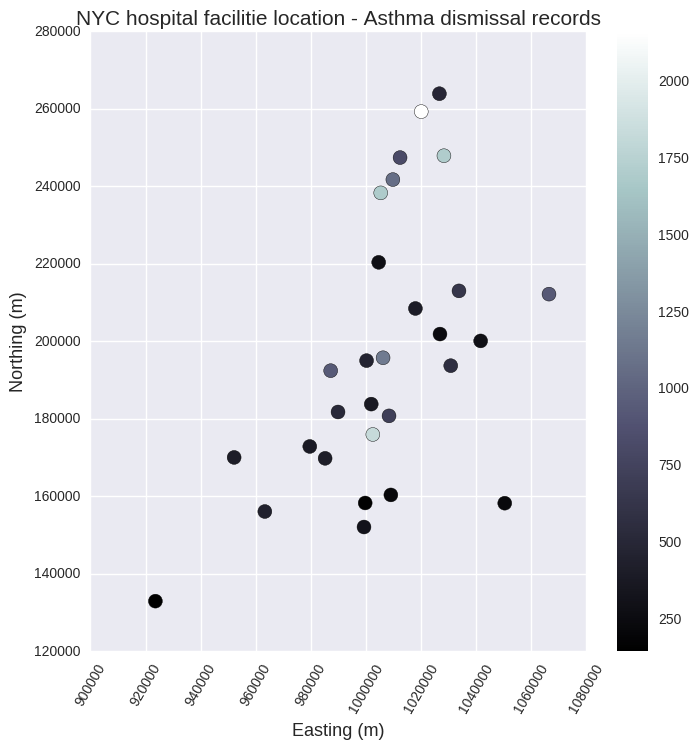

In [28]:
pl.figure(figsize=(8,8))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
pl.xlabel("Easting (m)", fontsize=13)
pl.xticks(rotation = 60)
pl.ylabel("Northing (m)", fontsize=13)
pl.title('NYC hospital facilitie location - Asthma dismissal records', fontsize=15)
pl.colorbar()

In [21]:
# Figure 1: The plot above shows location of NYC Hospitals on a northing vs. easting cordinate
# space and the colour density shows Asthma Dismissal counts

# ----------------------------Semi-Variogram-----------------------------------

In [30]:
# Semi-variogram

# Using code Federica provided
def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    #distance matrix (eucledian)
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N

    Z = list()
    for i in range(N):
        for j in range(i+1, N):
            #select only pair of points at the appropriate lag
            if( pdsv[i,j] >= h - bw )and( pdsv[i,j] <= h + bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    #print Z
    return np.sum( Z ) / ( 2.0 * len( Z ) )


def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append( SVh( P, h, bw ) )
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T

In [31]:
# lags in 100 meter increments from zero to 10,000
lag = 100 
hs = np.arange(0, 10000, lag)
bw = 100

In [32]:
sv = SV(krigdata, hs, bw)

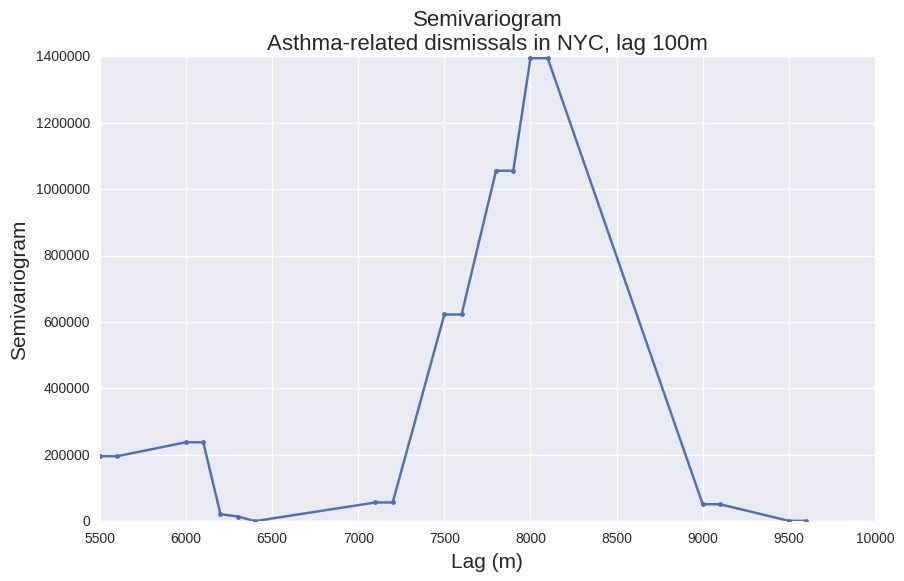

In [33]:
pl.figure(figsize = (10, 6))
plot(sv[0], sv[1], '.-' )
pl.xlabel('Lag (m)', fontsize = 15)
pl.ylabel('Semivariogram', fontsize = 15)
pl.title('Semivariogram\nAsthma-related dismissals in NYC, lag %dm'%lag, fontsize = 16) 
pl.show()

In [ ]:
# Figure 2. Based on the semivariogram, we observe no similarity in the number of asthma dismissals 
# based on the distance between zipcodes where these dismissals occur.

In [34]:
# Using code provided by Federica for different variogram models
def opt( fct, x, y, C0, meshSize=1000 ):
    parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]        


def spherical( h, a, C0 ):
    #print "sph"

    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit

    
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( spherical, h, a, C0 )

def exponentialngt(h, a, C0):
    #print "exp"
    '''
    Exponential model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-h/a)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )

    
def gaussianngt(h, a, C0):
    #print "gaus"
    '''
    Gaussian model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-(h/a)**2)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )



def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )



def cvmodel( P, model, hs, bw ):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponentialngt
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    #print C0
    # calculate the optimal parameters
    param = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a = param: C0 - model( h, a, C0 )
    return covfct

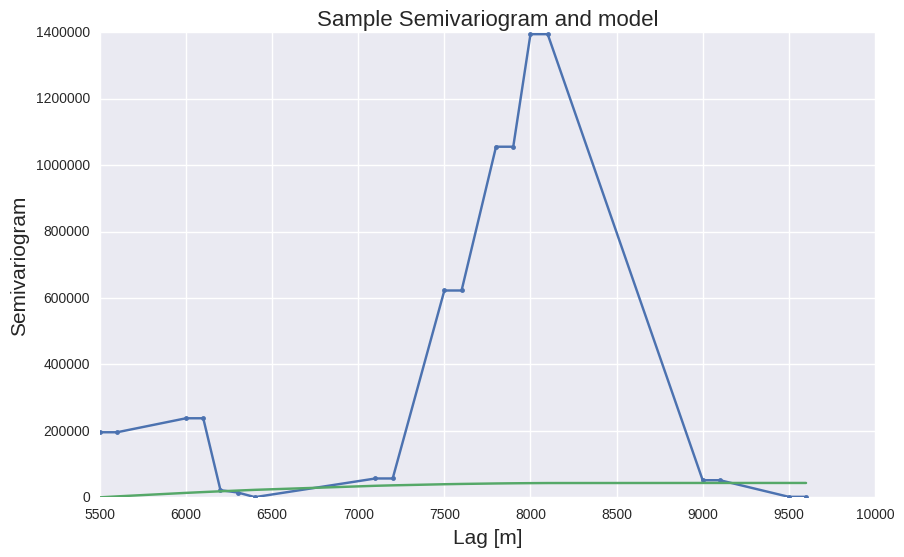

In [35]:
pl.figure(figsize=(10, 6))
sp = cvmodel(krigdata, model = spherical, hs = hs, bw = bw)
#print sp(mysv[0])
sphere = sp(sv[0])
plot(sv[0], sv[1], '.-' )
pl.plot(sv[0], -sphere+sphere.max())
pl.xlabel('Lag [m]', fontsize = 15)
pl.ylabel('Semivariogram', fontsize = 15)
pl.title('Sample Semivariogram and model', fontsize = 16)
pl.show()

In [36]:
# Figure 3. Model semivariogram shows no relationship as expected.